In [1]:
# Konfiguracja startowa
import pickle

DO_TRAIN = False  # czy trenowanie ma być wykonane na nowo, czy wczytane z dysku (jak z dysku to też zbiór testowy jest z dysku, augmentacja itd.)

def load_cache(fn):
    with open(fn, 'rb') as cf:
        return pickle.load(cf)


def write_cache(fn, data):
    with open(fn, 'wb') as cf:
        pickle.dump(data, cf)

In [2]:
# Załadowanie hitów w PNG z katalogu hit-images-final2
# z podziałem na "dot", "track" i "worm" (podkatalogi)

from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


CACHE_IMAGES = 'cache/images_v2.pickle'

ALL_SRC = 'wybrane_final'


def load_images(src):
    images = []
    files_used = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        img = Image.open(image_path)
        img = img.convert('L')
        image = np.asarray(img)
        #image = np.asarray(Image.open(image_path).convert('L'))
        image = align_image(image)
        mask = np.where(image > 25, 1, 0)
        image = mask * image
        if np.max(image) == 0:
            continue
        image = image.astype(np.float32) / np.max(image)
        image = np.expand_dims(image, 2)
        images.append(image)
        files_used.append(image_path)
    return np.asarray(images), files_used


if DO_TRAIN:
    all_set, all_files = load_images(ALL_SRC)
    write_cache(CACHE_IMAGES, [all_set, all_files])
else:
    [all_set, all_files] = load_cache(CACHE_IMAGES)

print('len(all_set): %d' % all_set.shape[0])

len(all_set): 13840


In [3]:
# augmentacja przez mirror, czyli pomnożenie próbek 2x przez dodanie lustrzanie odbitych

import pickle
CACHE_AUGMENTATION = 'cache/augmentation_v2.pickle'

def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug

if DO_TRAIN:
    all2_set, all2_files = augmentation_mirror(all_set, all_files)
    write_cache(CACHE_AUGMENTATION, [all2_set, all2_files])
else:
    [all2_set, all2_files] = load_cache(CACHE_AUGMENTATION)

print('len(dots2_set): %d' % all2_set.shape[0])

len(dots2_set): 27680


In [4]:
# wygenerowanie zbioru train, validate i test o proporcjach odpowiednio 60%, 20% i 20%
# zwracane listy zawierają indeksy próbek, które zostały przydzielone do ww. ziorów

import pickle
CACHE_DIV = 'cache/sets_tvt.pickle'

def train_validate_test_split(df, train_percent=.8, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    train = p[:n]
    validation = p[n:]
    return train, validation

if DO_TRAIN:
    all2_train, all2_validate = train_validate_test_split(all2_set)
    write_cache(CACHE_DIV, [all2_train, all2_validate])
else:
    [all2_train, all2_validate] = load_cache(CACHE_DIV)

print('len(all2_set): %d/%d' % (all2_train.shape[0], all2_validate.shape[0]))

len(all2_set): 22144/5536


In [5]:
# wytrenowanie kanałów
# * tracks
# * tnd (tracks and dots)

from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
#TRACKS_AC = 'cache/th_dots_optics_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'
ALL_AC = 'cache/th_all_%d.h5'

def train_and_test(train_set, validation_set, fn_template, latentDim=16):
    fn = fn_template % latentDim
    autoencoder = original_autoencoder(latentDim=latentDim)
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True, latentDim=latentDim)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)

if DO_TRAIN:
    for latentD in [16]:
        train_and_test(all2_set[all2_train], all2_set[all2_validate], ALL_AC, latentD)

In [6]:
if DO_TRAIN:
    for latentD in [2, 4, 6, 8, 12, 24, 32, 48, 64]:
        train_and_test(all2_set[all2_train], all2_set[all2_validate], ALL_AC, latentD)

In [7]:
# zapis embeddingu do pliku

from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

all_embedding = encoder_embedding(ALL_AC % 16, all_set)
all_embedding_files = np.hstack(all_files)


# np.save("res/emb_array_all_%d" % 16, all_embedding)

# with open("res/file_list_all.txt", 'w') as fp:
#     for ff in all_embedding_files:
#         fp.write(ff + "\n")


In [8]:
zero_to_one = (np.asarray(range(10)) + 1) / 10.0
one_to_ten = np.asarray(range(9)) + 2
ten_to_hundreds = (np.asarray(range(39)) + 2) * 10

eps_used = list((np.hstack([zero_to_one, one_to_ten, ten_to_hundreds])))
print(eps_used)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0]


260.000000: 101
wybrane_final\11078627.png
wybrane_final\11636367.png
wybrane_final\11823391.png
wybrane_final\11860397.png
wybrane_final\11860402.png
wybrane_final\11876681.png
wybrane_final\11883718.png
wybrane_final\11892228.png
wybrane_final\1208155.png
wybrane_final\13624927.png
wybrane_final\13831135.png
wybrane_final\13836130.png
wybrane_final\13843278.png
wybrane_final\13844465.png
wybrane_final\13855513.png
wybrane_final\15655784.png
wybrane_final\16200790.png
wybrane_final\20067047.png
wybrane_final\21229111.png
wybrane_final\22008402.png
wybrane_final\22010127.png
wybrane_final\22011869.png
wybrane_final\22013151.png
wybrane_final\22027241.png
wybrane_final\22027955.png
wybrane_final\22031737.png
wybrane_final\22031935.png
wybrane_final\22036077.png
wybrane_final\22037705.png
wybrane_final\22037785.png
wybrane_final\22038735.png
wybrane_final\22053032.png
wybrane_final\22054590.png
wybrane_final\22110467.png
wybrane_final\22110706.png
wybrane_final\22111155.png
wybrane_final

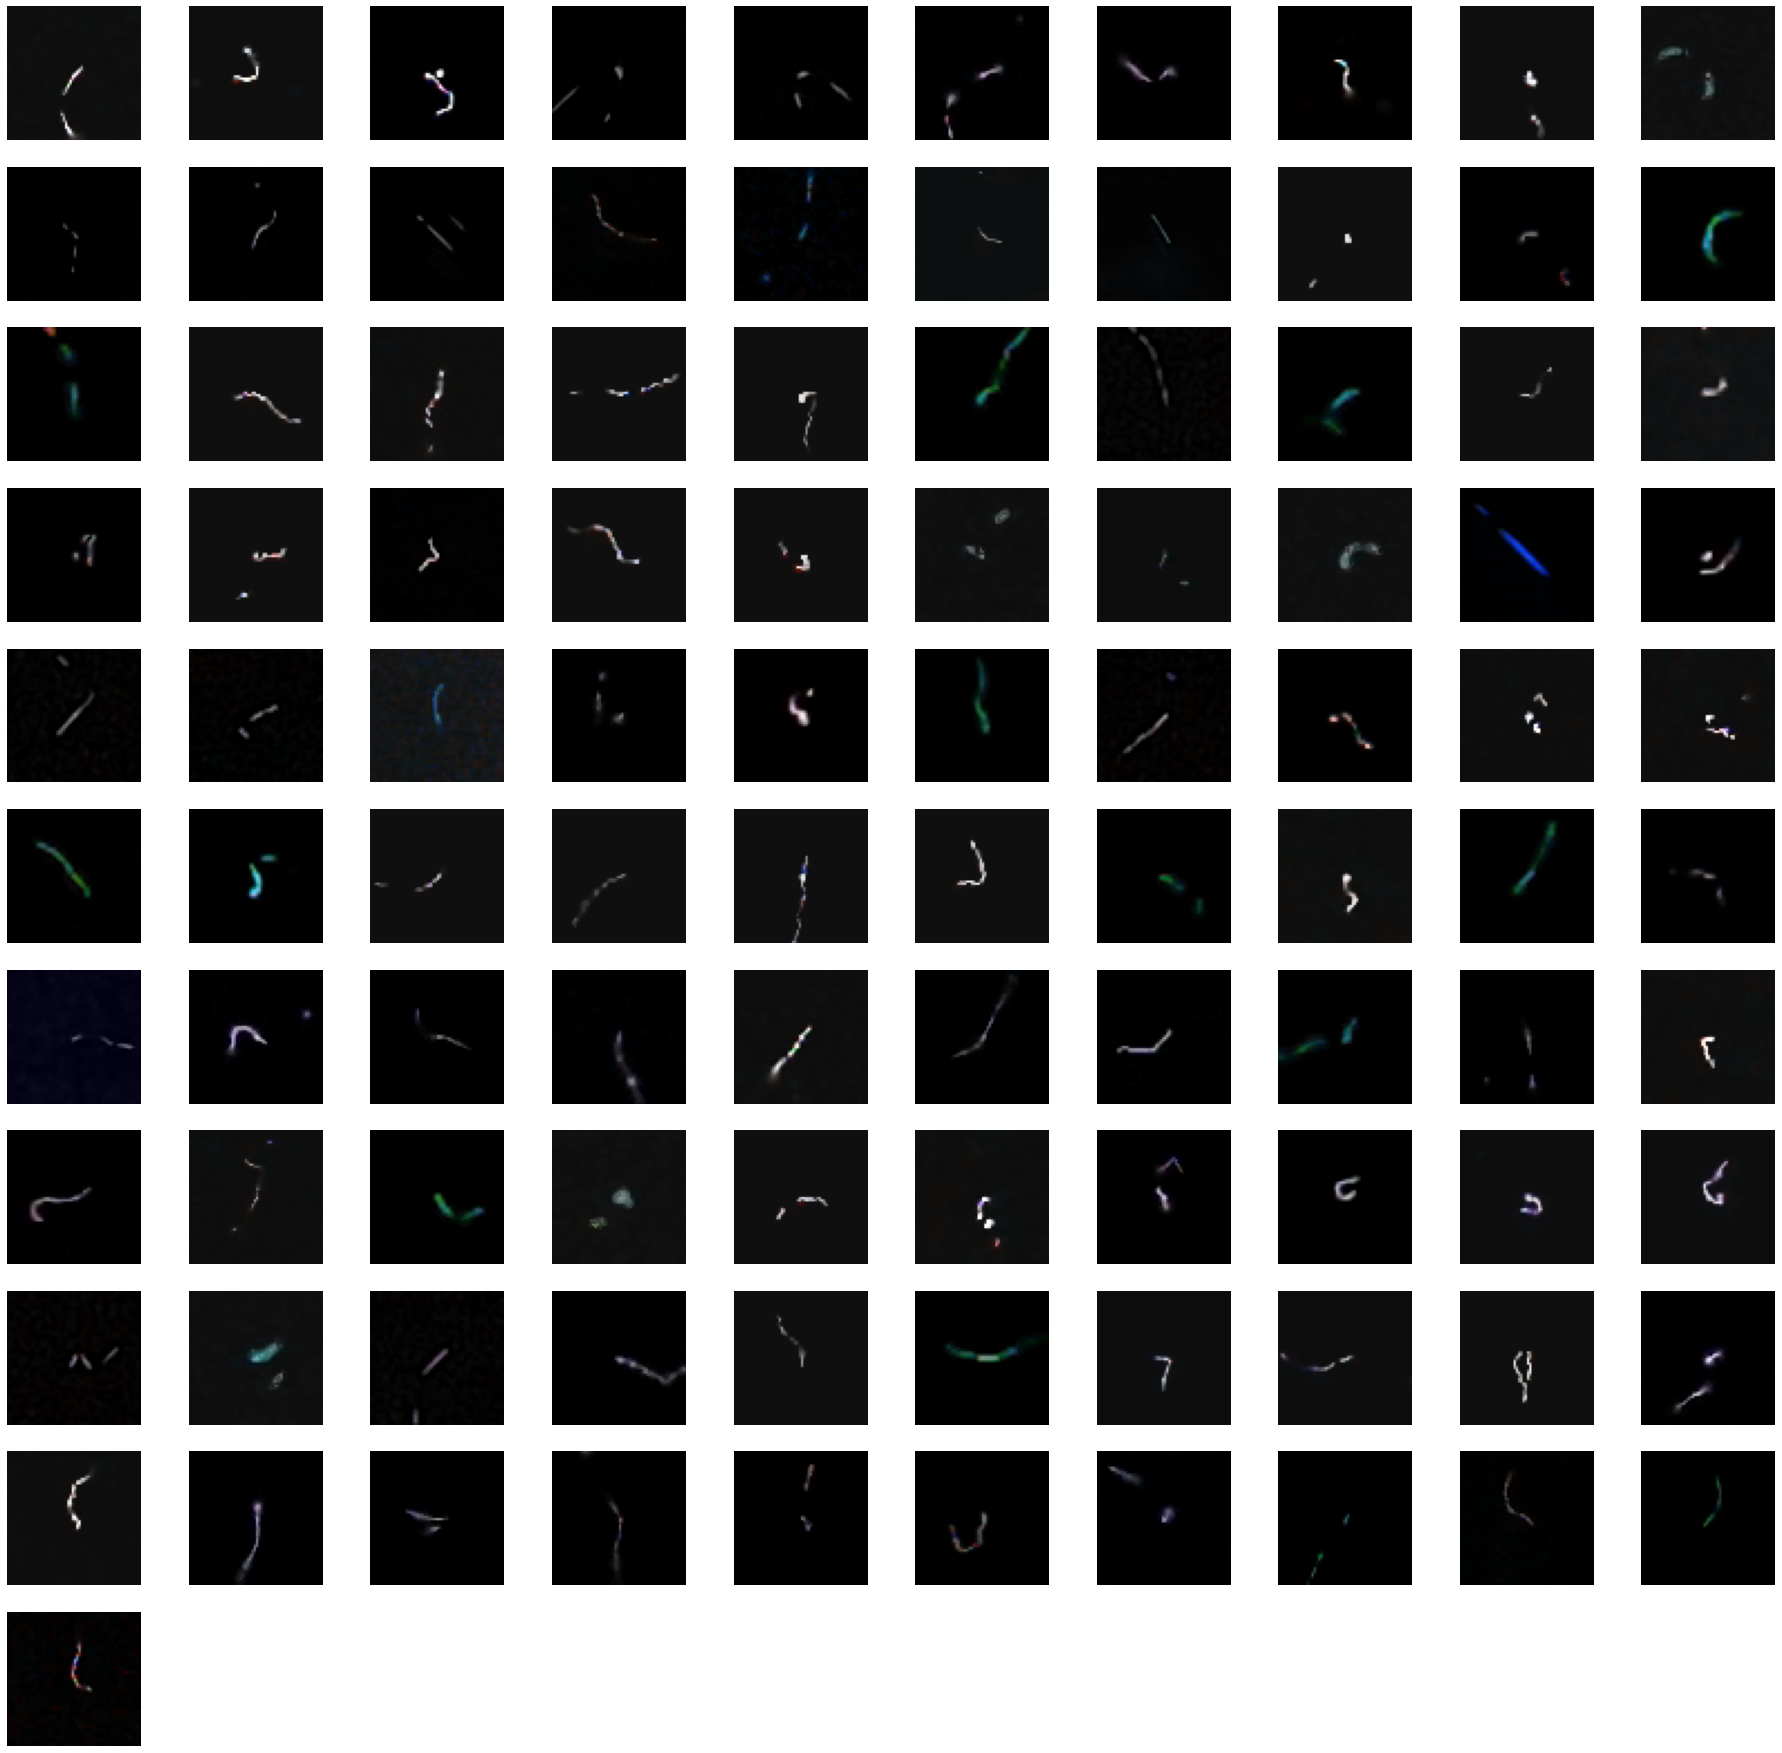

101

In [31]:
def dbscan(embedding, t_files, latentDim, eps, draw_cluster):
    img_count = embedding.shape[0]
    p = latentDim

    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import DBSCAN

    db = DBSCAN(min_samples=5, eps=eps).fit(emb_array_copy)
    labels = db.labels_
    result = np.where(labels == -1)
    my_ids = result[0]

    #print(labels)
    #print(my_ids)
    print('%f: %d' % (eps, len(my_ids)))

    if draw_cluster:
        import matplotlib.pyplot as plt


        fig = plt.figure(figsize=(32, 32))
        columns = 10
        rows = int(len(my_ids) / 10) + 1

        for aaa in range(len(my_ids)):
            img_help = cv2.imread(t_files[my_ids[aaa]])
            print(t_files[my_ids[aaa]])

            aaa1 = aaa + 1
            r = fig.add_subplot(rows, columns, aaa1)
            r.axis("off")
            plt.imshow(img_help)

        plt.show()
    return len(my_ids)

dbscan(all_embedding, all_files, 16, 260, True)
#for i in range(16):
#    dbscan(all_embedding, all_files), 16, eps=(i + 10) * 10, draw_cluster=True)

In [10]:
def dbscan_loop(emb_array, channel, latentDim):
    from sklearn.cluster import DBSCAN
    import timeit

    min_samples = [3, 4, 5, 6, 7, 8]
    eps = eps_used

    os.makedirs("results_dbscan_%s_%d" % (channel, latentDim), exist_ok=True)
    output_file = "results_dbscan_%s_%d/clusters" % (channel, latentDim)
    output_file_results = "results_dbscan_%s_%d/clusters.txt" % (channel, latentDim)
    for my_eps in eps:
        for my_min_samples in min_samples:
            start = timeit.default_timer()
            db = DBSCAN(eps=my_eps, min_samples=my_min_samples).fit(emb_array)
            stop = timeit.default_timer()
            elapsed_time = stop - start
            #print('Time: ', elapsed_time)

            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

            result = np.where(labels == -1)
            my_ids = result[0]
            #print(my_ids)
            output_file_ok = output_file + ",eps=" + str(my_eps) + ",min_samples=" + str(my_min_samples) + ".txt"
            #print(output_file_ok)

            with open(output_file_ok, 'w') as fp:
                for element in my_ids:
                    fp.write(str(element) + "\n")
            with open(output_file_results, 'a') as fp:
                fp.write(str(my_eps) + ","
                         + str(my_min_samples) + "," + str(n_clusters_) + "," + str(len(my_ids)) +
                         "," + str(elapsed_time) + "\n")

#dbscan_loop(all_embedding)

260.000000: 101
wybrane_final\11078627.png
wybrane_final\11636367.png
wybrane_final\11823391.png
wybrane_final\11860397.png
wybrane_final\11860402.png
wybrane_final\11876681.png
wybrane_final\11883718.png
wybrane_final\11892228.png
wybrane_final\1208155.png
wybrane_final\13624927.png
wybrane_final\13831135.png
wybrane_final\13836130.png
wybrane_final\13843278.png
wybrane_final\13844465.png
wybrane_final\13855513.png
wybrane_final\15655784.png
wybrane_final\16200790.png
wybrane_final\20067047.png
wybrane_final\21229111.png
wybrane_final\22008402.png
wybrane_final\22010127.png
wybrane_final\22011869.png
wybrane_final\22013151.png
wybrane_final\22027241.png
wybrane_final\22027955.png
wybrane_final\22031737.png
wybrane_final\22031935.png
wybrane_final\22036077.png
wybrane_final\22037705.png
wybrane_final\22037785.png
wybrane_final\22038735.png
wybrane_final\22053032.png
wybrane_final\22054590.png
wybrane_final\22110467.png
wybrane_final\22110706.png
wybrane_final\22111155.png
wybrane_final

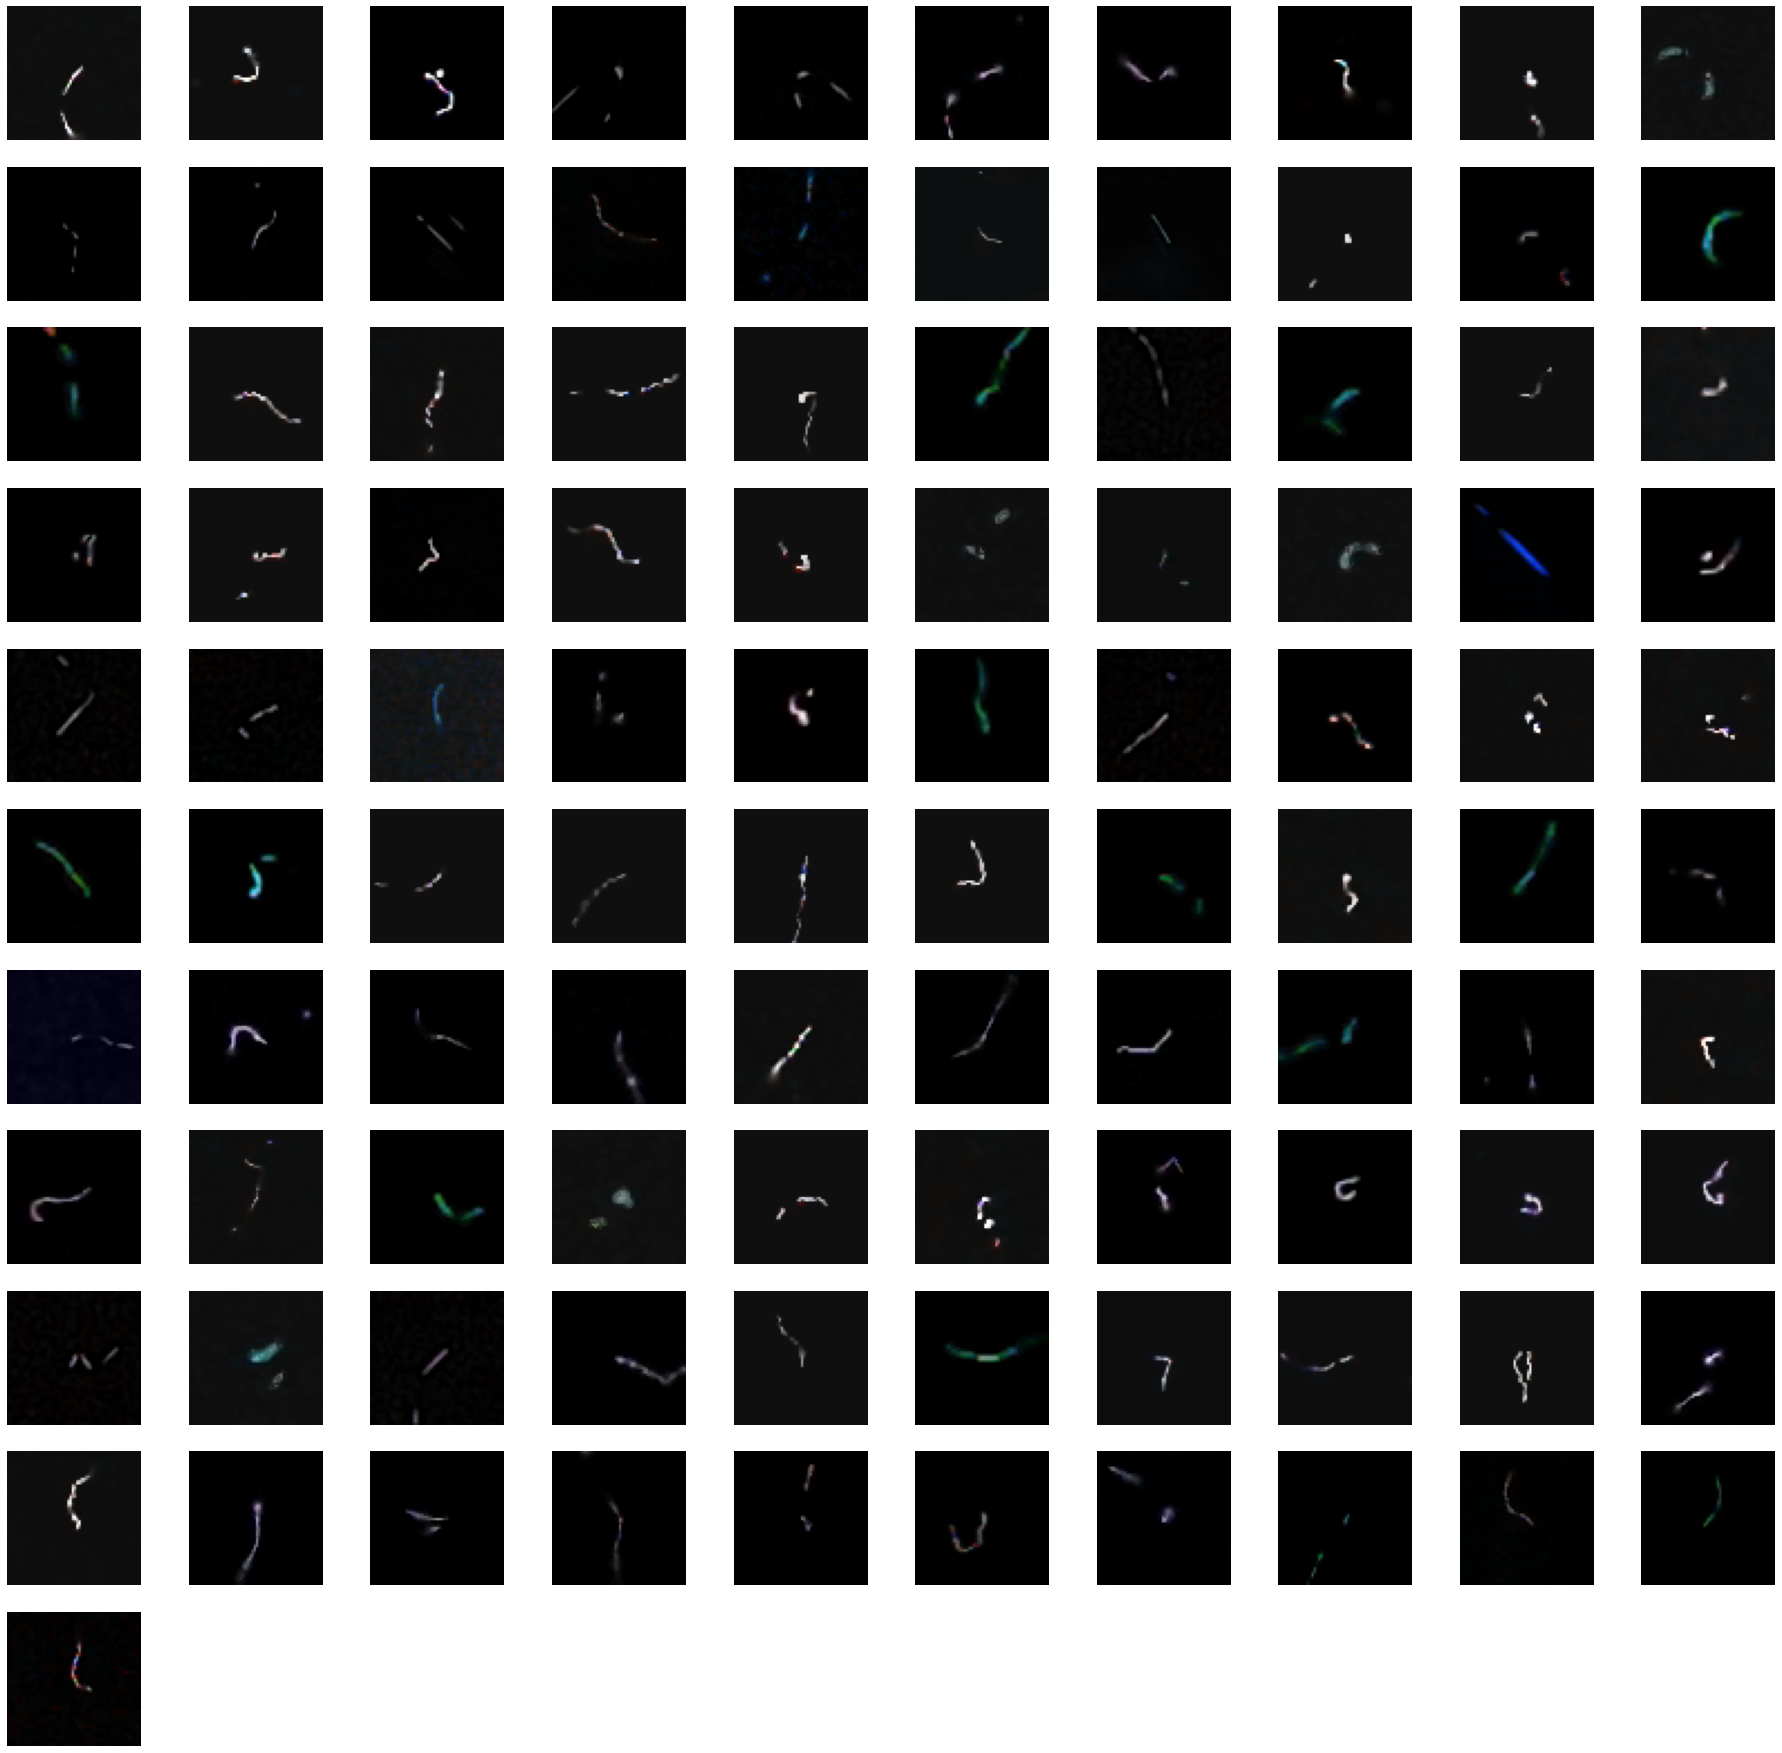

101

In [30]:
def optics(embedding, t_files, latentDim, eps, draw_cluster):
    img_count = embedding.shape[0]
    p = latentDim

    emb_array_copy = embedding # np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import OPTICS

    db = OPTICS(min_samples=5, cluster_method='dbscan', eps=eps).fit(emb_array_copy)
    labels = db.labels_
    result = np.where(labels == -1)
    my_ids = result[0]

    #print(labels)
    #print(my_ids)
    print('%f: %d' % (eps, len(my_ids)))

    if draw_cluster:
        import matplotlib.pyplot as plt


        fig = plt.figure(figsize=(32, 32))
        columns = 10
        rows = int(len(my_ids) / 10) + 1

        for aaa in range(len(my_ids)):
            img_help = cv2.imread(t_files[my_ids[aaa]])
            print(t_files[my_ids[aaa]])

            aaa1 = aaa + 1
            r = fig.add_subplot(rows, columns, aaa1)
            r.axis("off")
            plt.imshow(img_help)

        plt.show()
    return len(my_ids)

optics(all_embedding, all_files, 16, 260, True)
#for i in range(16):
#    optics(tnd_embedding, np.hstack([dots_files, tracks_files, worms_files]), 16, eps=(i + 10) * 10, draw_cluster=False)

In [12]:
def optics_loop(emb_array, channel, latentDim):
    from sklearn.cluster import OPTICS
    import timeit

    min_samples = [3, 4, 5, 6, 7, 8]
    eps = eps_used

    os.makedirs("results_OPTICS_%s_%d" % (channel, latentDim), exist_ok=True)
    output_file = "results_OPTICS_%s_%d/clusters" % (channel, latentDim)
    output_file_results = "results_OPTICS_%s_%d/clusters.txt" % (channel, latentDim)
    for my_eps in eps:
        for my_min_samples in min_samples:
            start = timeit.default_timer()
            #db = DBSCAN(eps=my_eps, min_samples=my_min_samples).fit(emb_array_copy)
            db = OPTICS(min_samples=my_min_samples, cluster_method='dbscan', eps=my_eps).fit(emb_array)

            stop = timeit.default_timer()
            elapsed_time = stop - start
            #print('Time: ', elapsed_time)

            #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            #core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)

            result = np.where(labels == -1)
            my_ids = result[0]
            #print(my_ids)
            output_file_ok = output_file + ",eps=" + str(my_eps) + ",min_samples=" + str(my_min_samples) + ".txt"
            #print(output_file_ok)

            with open(output_file_ok, 'w') as fp:
                for element in my_ids:
                    fp.write(str(element) + "\n")

            with open(output_file_results, 'a') as fp:
                fp.write(str(my_eps) + ","
                         + str(my_min_samples) + "," + str(n_clusters_) + "," + str(len(my_ids)) +
                         "," + str(elapsed_time) + "\n")

#optics_loop(all_embedding)

290.000000: 103
wybrane_final\11078627.png
wybrane_final\11636367.png
wybrane_final\11665291.png
wybrane_final\11813554.png
wybrane_final\11823391.png
wybrane_final\11856737.png
wybrane_final\11860397.png
wybrane_final\11860402.png
wybrane_final\11876681.png
wybrane_final\11881754.png
wybrane_final\1208155.png
wybrane_final\1255937.png
wybrane_final\13624927.png
wybrane_final\13663532.png
wybrane_final\13806422.png
wybrane_final\13831135.png
wybrane_final\13836130.png
wybrane_final\13836146.png
wybrane_final\13843278.png
wybrane_final\13844465.png
wybrane_final\13855513.png
wybrane_final\13892698.png
wybrane_final\15655784.png
wybrane_final\16200790.png
wybrane_final\19278255.png
wybrane_final\22010127.png
wybrane_final\22011955.png
wybrane_final\22027241.png
wybrane_final\22027955.png
wybrane_final\22031737.png
wybrane_final\22031935.png
wybrane_final\22033428.png
wybrane_final\22037785.png
wybrane_final\22038735.png
wybrane_final\22038737.png
wybrane_final\22053032.png
wybrane_final\

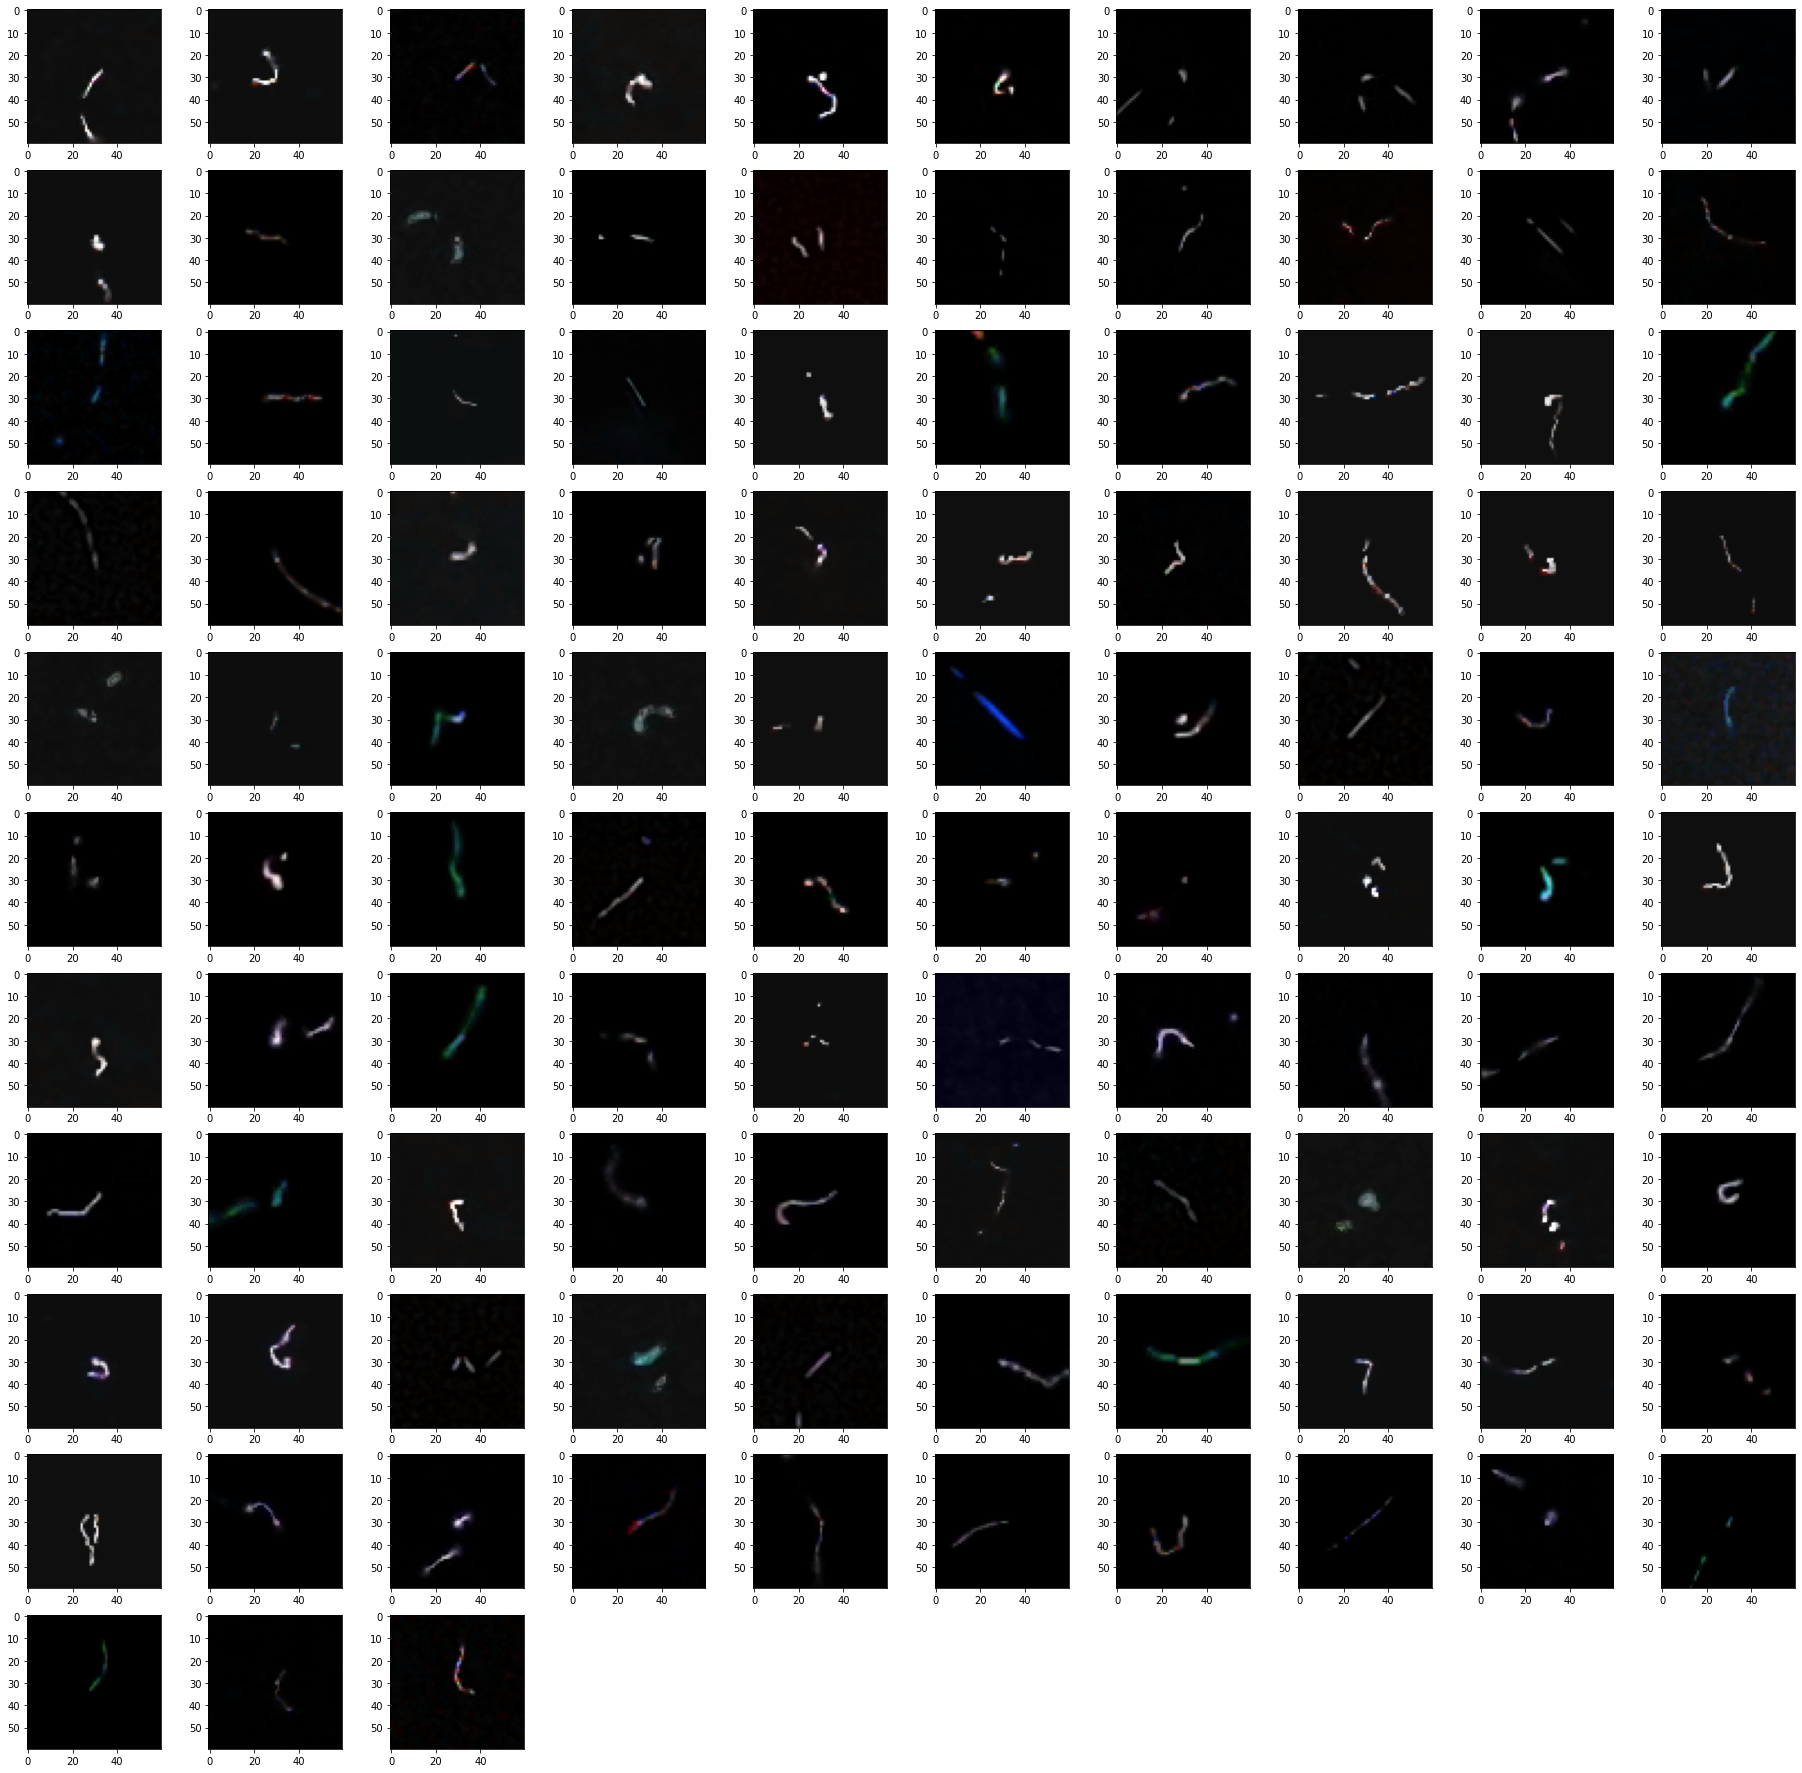

103

In [33]:
def algomerative(embedding, t_files, latentDim, eps, draw_cluster):
    img_count = len(embedding)
    p = latentDim

    emb_array_copy = np.copy(embedding[0:img_count, 0:p])

    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(distance_threshold = eps, n_clusters=None).fit(emb_array_copy)


    from collections import Counter
    c=Counter(clustering.labels_)
    values_list = list(c.values())
    keys_list = list(c.keys())

    def find_all_elements(my_list, id):
        ret_list = []
        for ind in range(len(my_list)):
            if my_list[ind] == id:
                ret_list.append(ind)
        return ret_list

    all_cluster_ids = []
    all_ids = find_all_elements(values_list, 1)
    for a in all_ids:
        all_cluster_ids.append(keys_list[a])
    #print(all_ids)
    #print(all_cluster_ids)

    my_ids = []
    for a in range(len(clustering.labels_)):
        if clustering.labels_[a] in all_cluster_ids:
            my_ids.append(a)
    #print(my_ids)
    print('%f: %d' % (eps, len(my_ids)))

    if draw_cluster:
        import matplotlib.pyplot as plt


        fig = plt.figure(figsize=(32, 32))
        columns = 10
        rows = int(len(my_ids) / 10) + 1

        columns2 = 11
        rows2 = int(len(my_ids) / columns2) + 1
        ret_img = np.zeros((128 * rows2, 128 * columns2, 3))

        xx = 0
        yy = 0
        for aaa in range(len(my_ids)):
            #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
            img_help = cv2.imread(t_files[my_ids[aaa]])
            print(t_files[my_ids[aaa]])
            aaa1 = aaa + 1

            ret_img[128 * yy : 128 * (yy + 1), 128 * xx : 128 * (xx + 1), :] = cv2.resize(img_help, (128, 128))
            xx = xx + 1

            if xx > columns2 - 1:
                xx = 0
                yy = yy + 1

            xxxxx = (aaa % 5) + 1



            fig.add_subplot(rows, columns, aaa1)
            plt.imshow(img_help)



            #cv2.imshow(str(aaa), img_help)
            #print(all_files_names[my_ids[0]])
        ret_img = ret_img.astype(np.uint8)
        cv2.imshow("ret_img",ret_img)
        plt.show()
    return len(my_ids)

algomerative(all_embedding, all_files, 16, 290, True)
#for i in range(21):
#    algomerative(tnd_embedding, np.hstack([dots_files, tracks_files, worms_files]), 16, eps=(i + 10) * 10, draw_cluster=False)

In [14]:
def agglomerative_loop(emb_array, channel, latentDim):
    from sklearn.cluster import AgglomerativeClustering
    import timeit
    from collections import Counter

    distance_thresholds = eps_used #list((np.asarray(range(31)) + 1) * 10)


    os.makedirs("results_AgglomerativeClustering_%s_%d" % (channel, latentDim), exist_ok=True)
    output_file = "results_AgglomerativeClustering_%s_%d/clusters" % (channel, latentDim)
    output_file_results = "results_AgglomerativeClustering_%s_%d/clusters.txt" % (channel, latentDim)

    for distance_threshold in distance_thresholds:
        start = timeit.default_timer()

        clustering = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None).fit(emb_array)
        stop = timeit.default_timer()
        elapsed_time = stop - start
        #print('Time: ', elapsed_time)

        c = Counter(clustering.labels_)
        values_list = list(c.values())
        keys_list = list(c.keys())


        # print(c.values())
        # print(c.keys())

        def find_all_elements(my_list, id):
            ret_list = []
            for ind in range(len(my_list)):
                if my_list[ind] == id:
                    ret_list.append(ind)
            return ret_list


        # xxxx = [1,1,2,3,4,5,1]
        # print(find_all_elements(xxxx, 1))

        all_cluster_ids = []
        all_ids = find_all_elements(values_list, 1)
        for a in all_ids:
            all_cluster_ids.append(keys_list[a])
        #print(all_ids)
        #print(all_cluster_ids)

        my_ids = []
        for a in range(len(clustering.labels_)):
            if clustering.labels_[a] in all_cluster_ids:
                my_ids.append(a)
        #print(my_ids)


        #print(my_ids)
        output_file_ok = output_file + ",distance_threshold=" + str(distance_threshold) + ".txt"
        #print(output_file_ok)

        with open(output_file_ok, 'w') as fp:
            for element in my_ids:
                fp.write(str(element) + "\n")

        with open(output_file_results, 'a') as fp:
            fp.write(str(distance_threshold) + ","
                     + str(len(my_ids)) + "," + str(elapsed_time) + "\n")

#agglomerative_loop(all_embedding)

In [15]:
from multiprocessing.pool import ThreadPool as Pool

def calc_loop(args):
    [latentDim, all_embedding, loop] = args

    #all_embedding = encoder_embedding(ALL_AC % latentDim, all_set)
    #all_embedding_files = all_files


    #np.save("res/emb_array_all_%d" % latentDim, all_embedding)

    #with open("res/file_list_all_%d.txt" % latentDim, 'w') as fp:
    #    for ff in all_embedding_files:
    #        fp.write(ff + "\n")

    loop(all_embedding, 'all', latentDim)
    #dbscan_loop(all_embedding, 'all', latentDim)
    #optics_loop(all_embedding, 'all', latentDim)
    #agglomerative_loop(all_embedding, 'all', latentDim)
    return 'Done for %s, latentDim=%f' % (str(loop), latentDim)

if DO_TRAIN:
    used_latentDim = [2, 4, 6, 8, 12, 16, 24, 32, 48, 64]
    jobs = []
    for latentDim in used_latentDim:
        print('Prepare for: ' + str(latentDim))
        all_embedding = encoder_embedding(ALL_AC % latentDim, all_set)
        for loop in [dbscan_loop, optics_loop, agglomerative_loop]:
            jobs.append([latentDim, all_embedding, loop])

    pool = Pool(20)
    for result in pool.imap_unordered(calc_loop, jobs):
        print(result)

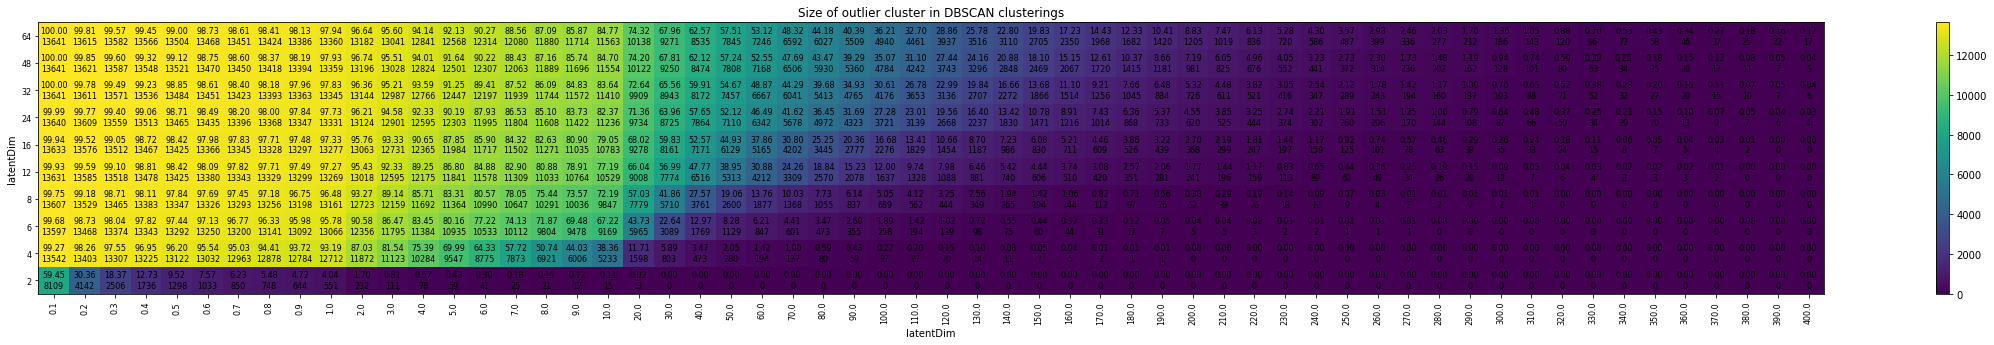

In [16]:
def counting_dbscan_latent(channel, used_latentDim):
    import matplotlib.pyplot as plt
    import numpy as np

    #min_samples = [3, 4, 5, 6, 7, 8]
    min_samples = [5]

    #eps = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    eps = eps_used

    all_results = []

    lbls = eps

    for latentDim in used_latentDim:
        results = []
        output_file = "results_dbscan_%s_%d/clusters" % (channel, latentDim)
        for my_eps in eps:
            for my_min_samples in min_samples:
                output_file_ok = output_file + ",eps=" + str(my_eps) + ",min_samples=" + str(my_min_samples) + ".txt"
                help_results = []
                with open(output_file_ok, 'r') as fp:
                    Lines = fp.readlines()
                    for line in Lines:
                        help_results.append(int(line))
                results.append(len(help_results))
                #all_results.append(help_results)
                #lbls.append(str(latentDim))
        all_results.append(results)

    import matplotlib.pyplot as plt
    import numpy as np

    #plt.viridis()
    #fig, ax = plt.subplots(1)
    #plt.viridis()

    p = np.zeros((len(all_results), len(eps)))

    #ax.pcolor(np.random.randn((10,10)))
    #ax.pcolor(np.random.randn(10), np.random.randn(10))

    for a in range(0, len(all_results)):
        for b in range(0, len(all_results[a])):
            #p[a,b] = OverlapCoefficient(all_results[a], all_results[b])
            #p[a, b] = SorensenCoefficient(all_results[a], all_results[b])
            #p[a, b] = JaccardSimilarity(all_results[a], all_results[b])
            p[a, b] = all_results[a][b]
        #lbls.append(str(a))

    #p = ax.pcolormesh(np.random.randn(10,10))
    #p = ax.pcolormesh(p)
    #fig.colorbar(p)
    plt.figure(figsize=(40, 5))
    cm = plt.pcolormesh(p)
    plt.colorbar(cm)


    plt.xticks(np.arange(0.5, len(lbls) + 0.5), lbls,rotation=90,fontsize=8)
    plt.yticks(np.arange(0.5, len(used_latentDim) + 0.5), used_latentDim, fontsize=8)

    plt.xlabel("latentDim")
    plt.ylabel("latentDim")
    #plt.title("Overlap coefficient of Agglomerative and DBSCAN clustering")
    #plt.title("Sorensen coefficient of Agglomerative and DBSCAN clustering")
    plt.title("Size of outlier cluster in DBSCAN clusterings")

    #for a in range(0, len(all_results)):
    #    for b in range(a + 1, len(all_results)):
    for a in range(len(all_results)):
        for b in range(len(all_results[a])):
            plt.text((b+0.5), a+0.3,"{:.0f}".format((p[a,b])), ha='center',va='center', size=8,color='black')
            plt.text((b+0.5), a+0.7,"{:.2f}".format((p[a,b]*100.0/13641)), ha='center',va='center', size=8,color='black')

    plt.show()


counting_dbscan_latent('all', [2, 4, 6, 8, 12, 16, 24, 32, 48, 64])

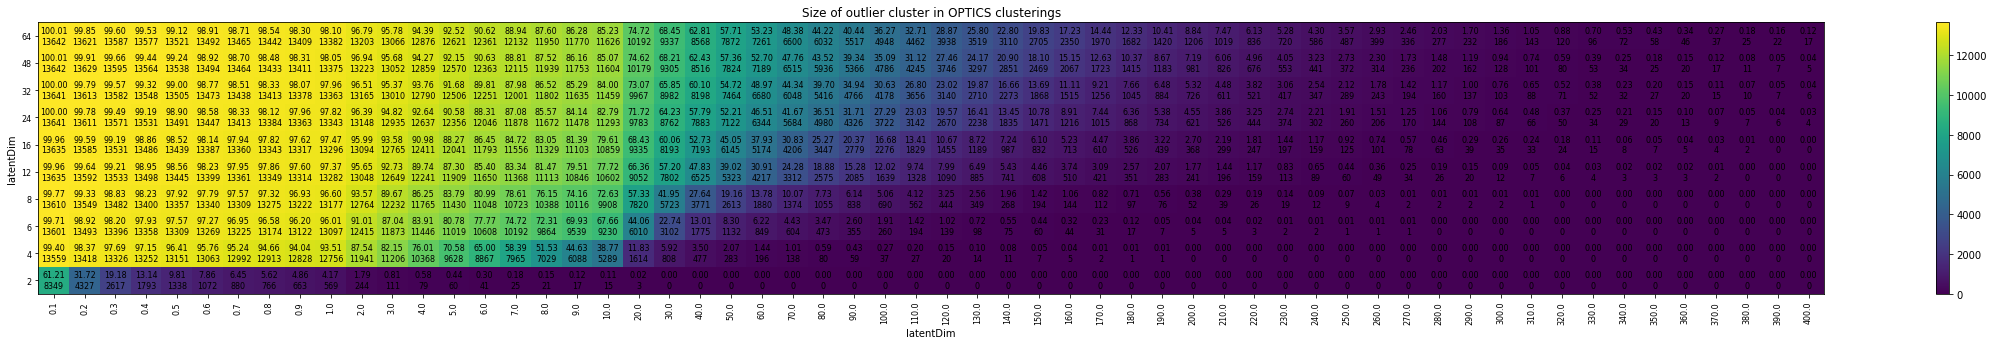

In [17]:
def counting_optics_latent(channel, used_latentDim):
    import matplotlib.pyplot as plt
    import numpy as np

    #min_samples = [3, 4, 5, 6, 7, 8]
    min_samples = [5]

    #eps = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    eps = eps_used

    all_results = []

    lbls = eps

    for latentDim in used_latentDim:
        results = []
        output_file = "results_OPTICS_%s_%d/clusters" % (channel, latentDim)
        for my_eps in eps:
            for my_min_samples in min_samples:
                output_file_ok = output_file + ",eps=" + str(my_eps) + ",min_samples=" + str(my_min_samples) + ".txt"
                help_results = []
                with open(output_file_ok, 'r') as fp:
                    Lines = fp.readlines()
                    for line in Lines:
                        help_results.append(int(line))
                results.append(len(help_results))
                #all_results.append(help_results)
                #lbls.append(str(latentDim))
        all_results.append(results)

    import matplotlib.pyplot as plt
    import numpy as np

    #plt.viridis()
    #fig, ax = plt.subplots(1)
    #plt.viridis()

    p = np.zeros((len(all_results), len(eps)))

    #ax.pcolor(np.random.randn((10,10)))
    #ax.pcolor(np.random.randn(10), np.random.randn(10))

    for a in range(0, len(all_results)):
        for b in range(0, len(all_results[a])):
            #p[a,b] = OverlapCoefficient(all_results[a], all_results[b])
            #p[a, b] = SorensenCoefficient(all_results[a], all_results[b])
            #p[a, b] = JaccardSimilarity(all_results[a], all_results[b])
            p[a, b] = all_results[a][b]
        #lbls.append(str(a))

    #p = ax.pcolormesh(np.random.randn(10,10))
    #p = ax.pcolormesh(p)
    #fig.colorbar(p)
    plt.figure(figsize=(40, 5))
    cm = plt.pcolormesh(p)
    plt.colorbar(cm)


    plt.xticks(np.arange(0.5, len(lbls) + 0.5), lbls,rotation=90,fontsize=8)
    plt.yticks(np.arange(0.5, len(used_latentDim) + 0.5), used_latentDim, fontsize=8)

    plt.xlabel("latentDim")
    plt.ylabel("latentDim")
    #plt.title("Overlap coefficient of Agglomerative and DBSCAN clustering")
    #plt.title("Sorensen coefficient of Agglomerative and DBSCAN clustering")
    plt.title("Size of outlier cluster in OPTICS clusterings")

    #for a in range(0, len(all_results)):
    #    for b in range(a + 1, len(all_results)):
    for a in range(len(all_results)):
        for b in range(len(all_results[a])):
            plt.text((b+0.5), a+0.3,"{:.0f}".format((p[a,b])), ha='center',va='center', size=8,color='black')
            plt.text((b+0.5), a+0.7,"{:.2f}".format((p[a,b]*100.0/13641)), ha='center',va='center', size=8,color='black')

    plt.show()


counting_optics_latent('all', [2, 4, 6, 8, 12, 16, 24, 32, 48, 64])

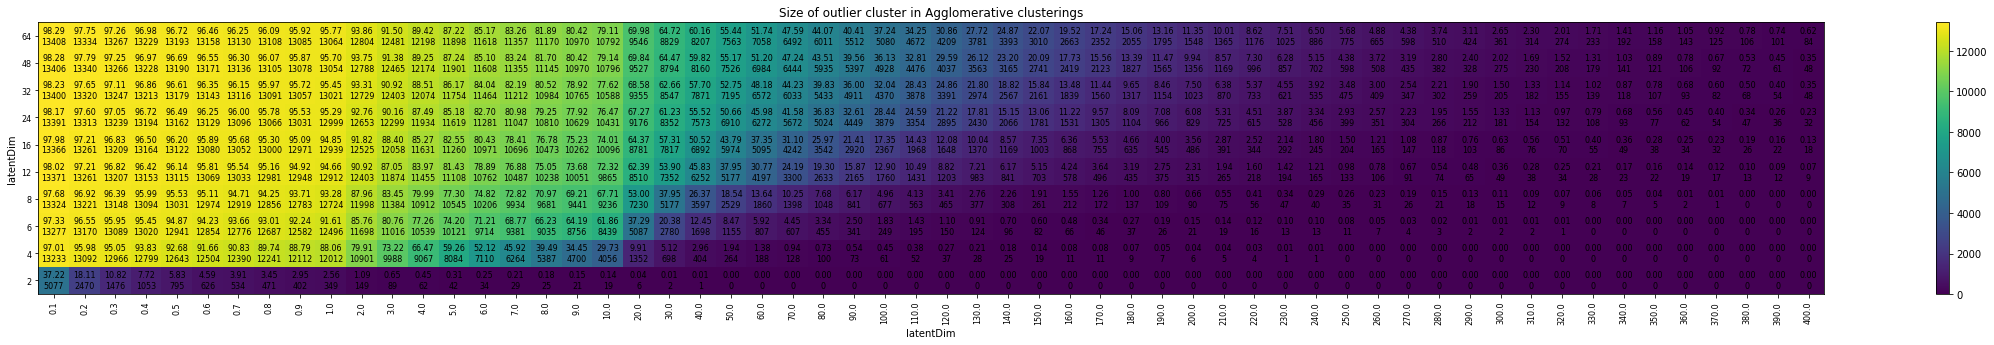

In [18]:
def counting_agglomerative_latent(channel, used_latentDim):
    import matplotlib.pyplot as plt
    import numpy as np

    #min_samples = [3, 4, 5, 6, 7, 8]
    min_samples = [5]

    #eps = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    eps = eps_used

    all_results = []

    lbls = eps

    for latentDim in used_latentDim:
        results = []
        output_file = "results_AgglomerativeClustering_%s_%d/clusters" % (channel, latentDim)
        for my_eps in eps:
            for my_min_samples in min_samples:
                output_file_ok = output_file + ",distance_threshold=" + str(my_eps) + ".txt"
                help_results = []
                with open(output_file_ok, 'r') as fp:
                    Lines = fp.readlines()
                    for line in Lines:
                        help_results.append(int(line))
                results.append(len(help_results))
                #all_results.append(help_results)
                #lbls.append(str(latentDim))
        all_results.append(results)

    import matplotlib.pyplot as plt
    import numpy as np

    #plt.viridis()
    #fig, ax = plt.subplots(1)
    #plt.viridis()

    p = np.zeros((len(all_results), len(eps)))

    #ax.pcolor(np.random.randn((10,10)))
    #ax.pcolor(np.random.randn(10), np.random.randn(10))

    for a in range(0, len(all_results)):
        for b in range(0, len(all_results[a])):
            #p[a,b] = OverlapCoefficient(all_results[a], all_results[b])
            #p[a, b] = SorensenCoefficient(all_results[a], all_results[b])
            #p[a, b] = JaccardSimilarity(all_results[a], all_results[b])
            p[a, b] = all_results[a][b]
        #lbls.append(str(a))

    #p = ax.pcolormesh(np.random.randn(10,10))
    #p = ax.pcolormesh(p)
    #fig.colorbar(p)
    plt.figure(figsize=(40, 5))
    cm = plt.pcolormesh(p)
    plt.colorbar(cm)


    plt.xticks(np.arange(0.5, len(lbls) + 0.5), lbls,rotation=90,fontsize=8)
    plt.yticks(np.arange(0.5, len(used_latentDim) + 0.5), used_latentDim, fontsize=8)

    plt.xlabel("latentDim")
    plt.ylabel("latentDim")
    #plt.title("Overlap coefficient of Agglomerative and DBSCAN clustering")
    #plt.title("Sorensen coefficient of Agglomerative and DBSCAN clustering")
    plt.title("Size of outlier cluster in Agglomerative clusterings")

    #for a in range(0, len(all_results)):
    #    for b in range(a + 1, len(all_results)):
    for a in range(len(all_results)):
        for b in range(len(all_results[a])):
            plt.text((b+0.5), a+0.3,"{:.0f}".format((p[a,b])), ha='center',va='center', size=8,color='black')
            plt.text((b+0.5), a+0.7,"{:.2f}".format((p[a,b]*100.0/13641)), ha='center',va='center', size=8,color='black')

    plt.show()


counting_agglomerative_latent('all', [2, 4, 6, 8, 12, 16, 24, 32, 48, 64])